In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
from scipy import stats
from matplotlib.patches import Rectangle

Due to the 'larger' filesize, we need a new method to process our data. Since we just want to save everything to a dataframe it suffices to generate it in chunks or using dask rather than using a 'lazy' generator to process the data first.

In [75]:
# setting up our dataframe
dataPath = 'QVI_data.csv'
datatfr = pd.read_csv(dataPath, chunksize = 100000, iterator = True)
df = pd.concat(datatfr, ignore_index = True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df.head())


   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000  2018-10-17          1       1         5   
1            1002  2018-09-16          1       2        58   
2            1003  2019-03-07          1       3        52   
3            1003  2019-03-08          1       4       106   
4            1004  2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
1         RRD  YOUNG SINGLES/COUPLES       Mainstrea

We want to find stores that are similar to the trial stores (77,86,88) that the client selected. We can measure this similarity by considering the monthly sales revenue and number of customers among other metrics such as average transactional data.

We start by computing the monthly total for each of our metrics.

In [76]:
# convert date to pd.datatime<datetime> object then format as needed
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEAR_MONTH'] = df['DATE'].dt.strftime('%Y%m').astype('int64')
print(df.head())

   LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000 2018-10-17          1       1         5   
1            1002 2018-09-16          1       2        58   
2            1003 2019-03-07          1       3        52   
3            1003 2019-03-08          1       4       106   
4            1004 2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  YEAR_MONTH  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium      201810  
1         RRD  YOUNG SINGLES/COUPL

Want to compute:
1. total sales
2. total customers
3. transactions per customer
4. quantity per customer
5. average transaction price per customer

These need to be computed for each store on a monthly basis. It is also important to note that we are only interested in stores that have data in every month of our observation range. We also only need to keep data from the pre-trial period.

In [95]:
# metrics that need to be computed on 'STORE_NBR' and 'YEAR_MONTH'
grp = df.groupby(['STORE_NBR', 'YEAR_MONTH'])
TOTAL_SALES = grp.TOT_SALES.sum()
TOTAL_CUST = grp.LYLTY_CARD_NBR.nunique()
TRANS_PER_CUST = grp.TXN_ID.size()/TOTAL_CUST
QUANT_PER_CUST = grp.PROD_QTY.sum()/grp.TXN_ID.size()
AVG_PRICE = TOTAL_SALES/grp.PROD_QTY.sum()

# store all of these new metrics in a dataframe
metrics = [TOTAL_SALES, TOTAL_CUST, TRANS_PER_CUST, QUANT_PER_CUST, AVG_PRICE]
dfMetrics = pd.concat(metrics, axis = 1)
dfMetrics.columns = ['TOTAL_SALES', 'TOTAL_CUST', 'TRANS_PER_CUST', 'QUANT_PER_CUST', 'AVG_PRICE']
dfMetrics = dfMetrics.reset_index()

# filter for our observaton period
months = dfMetrics.groupby('STORE_NBR').YEAR_MONTH.nunique().reset_index()
stores = months[months.YEAR_MONTH == 12].STORE_NBR
pretrial = dfMetrics[dfMetrics['STORE_NBR'].isin(stores)]

# filter for pretrial
pretrial = pretrial.loc[pretrial.YEAR_MONTH < 201902]
pretrial2 = pretrial.copy()
print(pretrial.head())

   STORE_NBR  YEAR_MONTH  TOTAL_SALES  TOTAL_CUST  TRANS_PER_CUST  \
0          1      201807        206.9          49        1.061224   
1          1      201808        176.1          42        1.023810   
2          1      201809        278.8          59        1.050847   
3          1      201810        188.1          44        1.022727   
4          1      201811        192.6          46        1.021739   

   QUANT_PER_CUST  AVG_PRICE  
0        1.192308   3.337097  
1        1.255814   3.261111  
2        1.209677   3.717333  
3        1.288889   3.243103  
4        1.212766   3.378947  


Next we want to find out how simliar each store is to the trial store by correlating these metrics. In order to do this we need two things: 

1. A function which calculates the correlation based on a single metric
2. A function which calculates a normalised magnitude difference

In [78]:
# correlation function
def correlation(trial, metrics, metricData = pretrial):
    '''
    This function will compute the correlation between a trial store and all other stores using the metrics we have defined.
    '''
    trialStores = [77,86,88]
    ctrStores = stores[~stores.isin(trialStores)]
    
    # define containers to store our correlations values as well as the trial values
    trialValues = metricData[metricData['STORE_NBR'] == trial][metrics].reset_index()
    dfCorr = pd.DataFrame(columns = ['YEAR_MONTH', 'TRIAL_STORE', 'CONTROL_STORE', 'CORRELATION'])
    
    # compute correlations for each control store and store in our dataframe
    for store in ctrStores:
        ctrValue = metricData[metricData['STORE_NBR'] == store][metrics].reset_index()
        corr_row = pd.DataFrame(columns = ['YEAR_MONTH', 'TRIAL_STORE', 'CONTROL_STORE', 'CORRELATION'])
        corr_row.YEAR_MONTH = list(metricData.loc[metricData.STORE_NBR == store]['YEAR_MONTH'])
        corr_row.TRIAL_STORE = trial
        corr_row.CONTROL_STORE = store
        corr_row.CORRELATION = ctrValue.corrwith(trialValues, axis=1)
        dfCorr = pd.concat([dfCorr, corr_row])
    return dfCorr

We now define the function to calculate the normalised margnitude difference between two metrics.

In [79]:
# distance function
def dist(trial, metrics, metricData = pretrial):
    '''
    This function computes a normalised magnitude for the distance between a trial store and a control store.
    '''
    trialStores = [77,86,88]
    ctrStores = stores[~stores.isin(trialStores)]
    
    # define container to store our distance data
    dfDist = pd.DataFrame()
    
    for store in ctrStores:
        line = pd.DataFrame()
        line = abs(metricData[metricData['STORE_NBR'] == trial].reset_index()[metrics]-metricData[metricData['STORE_NBR'] == store].reset_index()[metrics])
        line.insert(0, 'YEAR_MONTH', list(metricData.loc[metricData.STORE_NBR == trial]['YEAR_MONTH']))
        line.insert(1, 'TRIAL_STORE', trial)
        line.insert(2, 'CONTROL_STORE', store)
        dfDist = pd.concat([dfDist,line])
    
    # now that we ahve the distance magnitudes we need to normalise our data
    for col in metrics:
        maxDist = dfDist[col].max()
        minDist = dfDist[col].min()
        dfDist[col] = 1-(dfDist[col] - minDist)/(maxDist - minDist)
    dfDist['MAGNITUDE'] = dfDist[metrics].mean(axis=1)
    return dfDist

We can use these function to find the control stores we want. We also need to calculate average correlations and distanced for every store. Only then can we compute the most likely candidates for ontrol stores by averaging over the monthly sales and ustomer data. We will write a function for each task.

In [80]:
# compute correlations and distances for each store
def calcCorrDist(trial, metrics, metricData = pretrial):
    '''
    Using the previous two functions we can compute the average correlations and distances ovre the pretrial months for a given store
    '''
    corrScore = correlation(trial, metrics, metricData)
    magDistScore = dist(trial, metrics, metricData)
    magDistScore = magDistScore.drop(metrics, axis = 1)
    
    # combine our scores and average over the pretrial months
    combinedScores = pd.merge(corrScore, magDistScore, on=['YEAR_MONTH','TRIAL_STORE','CONTROL_STORE'])
    avgScores = combinedScores.groupby(['TRIAL_STORE','CONTROL_STORE']).mean().reset_index()
    
    # now take a weighted average using a simple average
    avgScores['COMBINED_SCORE'] = 0.5*avgScores['CORRELATION'] + (0.5)*avgScores['MAGNITUDE']
    return avgScores

In [81]:
# compute the control stores which have the highest correlation score to our trial stores
def calcScores(trial):
    '''
    Compute the correlation scores for total sales and customer numbers for each store and combine the scores in an ordered dataframe
    '''
    salesScores = calcCorrDist(trial,['TOTAL_SALES'])
    custScores = calcCorrDist(trial, ['TOTAL_CUST'])
    ctrScores = pd.DataFrame()
    ctrScores['CONTROL_STORE'] = salesScores.CONTROL_STORE
    ctrScores['CORRELATION'] = 0.5*salesScores.CORRELATION + 0.5*custScores.CORRELATION
    ctrScores['MAGNITUDE'] = 0.5*salesScores.MAGNITUDE + 0.5*custScores.MAGNITUDE
    ctrScores['SCORES']  = 0.5*salesScores.COMBINED_SCORE + 0.5*custScores.COMBINED_SCORE
    return(ctrScores.sort_values(by= 'SCORES', ascending = False).reset_index(drop=True).head(5))

Now that our functions are set up we can compute the control stores which have the highest average score compared to our trial stores.

In [82]:
trialStores = [77,86,88]
for store in trialStores:
    print('Correlation for trial store: ' + str(store))
    print(calcScores(store))

Correlation for trial store: 77
   CONTROL_STORE  CORRELATION  MAGNITUDE    SCORES
0            233          1.0   0.989804  0.994902
1             41          1.0   0.972041  0.986020
2             46          1.0   0.969523  0.984762
3             53          1.0   0.968421  0.984211
4            111          1.0   0.967981  0.983991
Correlation for trial store: 86
   CONTROL_STORE  CORRELATION  MAGNITUDE    SCORES
0            155          1.0   0.976324  0.988162
1            109          1.0   0.968180  0.984090
2            225          1.0   0.965044  0.982522
3            229          1.0   0.957995  0.978997
4            101          1.0   0.945394  0.972697
Correlation for trial store: 88
   CONTROL_STORE  CORRELATION  MAGNITUDE    SCORES
0             40          1.0   0.941789  0.970895
1             26          1.0   0.917859  0.958929
2             72          1.0   0.908157  0.954079
3             58          1.0   0.900435  0.950217
4             81          1.0   0.887

By looking at the stores which have the highest scores we can pick our control stores. 
Trial store 77 -> Store 233
Trial store 86 -> Store 155
Trial store 88 -> Store 40

Comparitively, 88 has a lower score than the other controls we have picked which may me it is not as close a match as the other pairs.

Now we can visualise the similarity between these stores

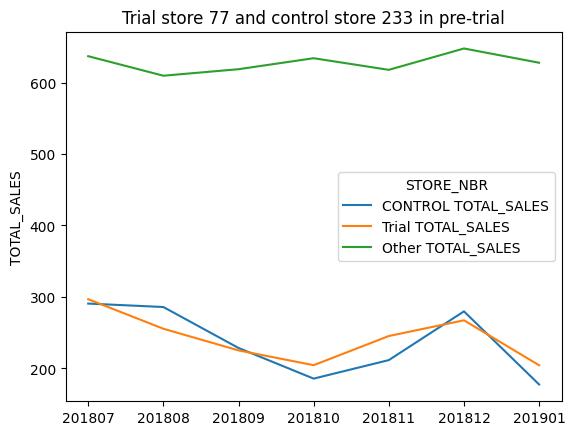

<Figure size 1500x1000 with 0 Axes>

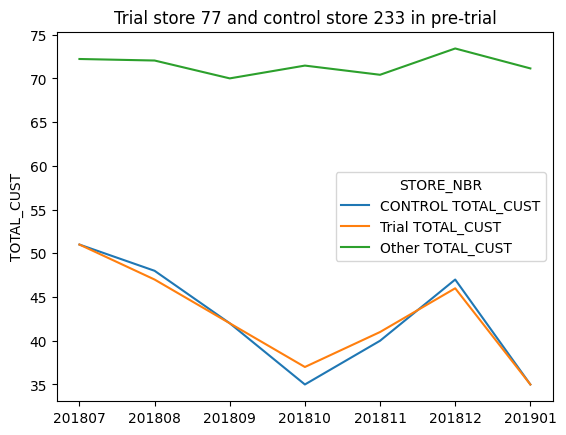

<Figure size 1500x1000 with 0 Axes>

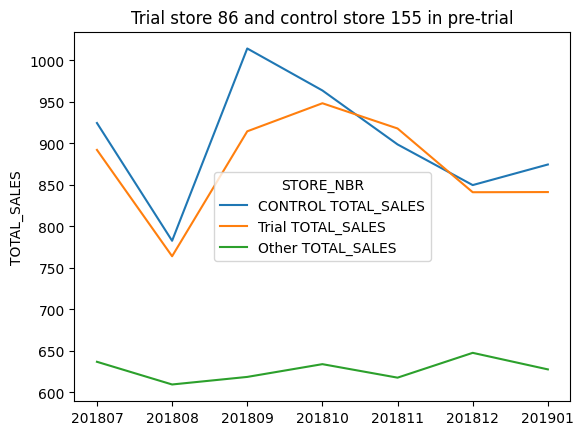

<Figure size 1500x1000 with 0 Axes>

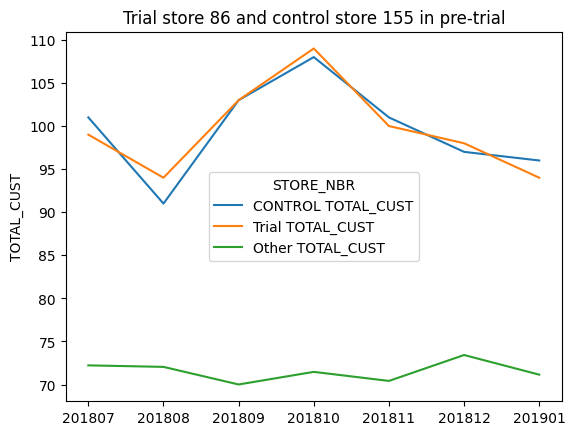

<Figure size 1500x1000 with 0 Axes>

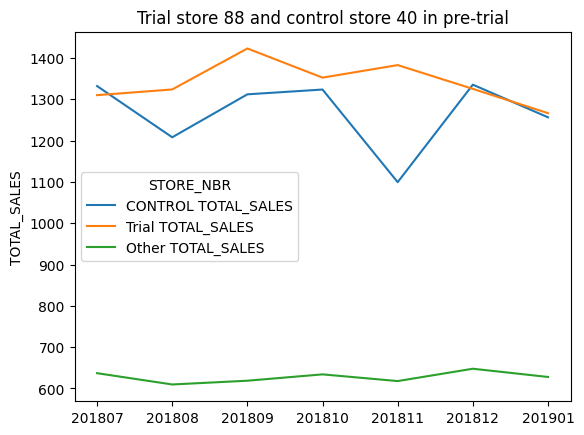

<Figure size 1500x1000 with 0 Axes>

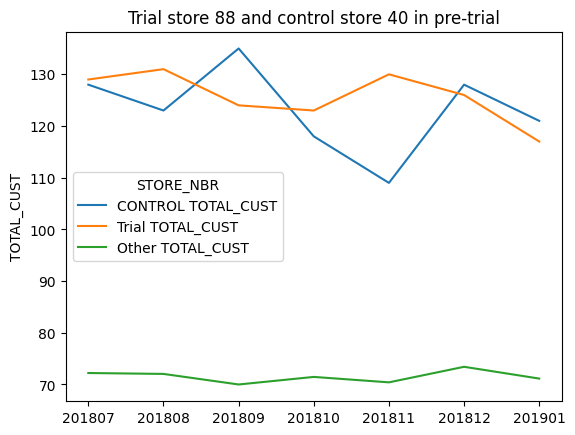

<Figure size 1500x1000 with 0 Axes>

In [83]:
simStores = [[77,233], [86,155], [88,40]]
compMetrics = ['TOTAL_SALES', 'TOTAL_CUST']

# for each store pair we want to visualise their similarity wrt. each of the comparison metrics we are interested in

for stores in simStores:
    for metric in compMetrics:
        # we want to separate the YEAR_MONTH and STORE_NBR for each pair of similar stores as well as the average values for all the other stores excluding our pairs. We can then visualise each of the results seperately.
        trial = stores[0]
        control = stores[1]
        trialData = pretrial[pretrial.STORE_NBR == trial][['YEAR_MONTH', 'STORE_NBR', metric]]
        trialData = trialData.rename(columns = {metric: metric +'_TRIAL'})
        ctrData = pretrial[pretrial.STORE_NBR == control][['YEAR_MONTH','STORE_NBR', metric]]
        ctrData = ctrData.rename(columns = {metric:metric+'_CONTROL'})
        otherStores = pretrial.loc[(pretrial.STORE_NBR != 77)][['YEAR_MONTH','STORE_NBR', metric]]
        otherStores = otherStores.loc[(pretrial.STORE_NBR != 233)]
        otherStores = otherStores.loc[(pretrial.STORE_NBR != 155)]
        otherStoreData =otherStores.groupby('YEAR_MONTH')[metric].mean()
        
        # now we can plot each of those datasets onto a graph
        ax = ctrData.plot.line(x = 'YEAR_MONTH', y = metric+'_CONTROL', use_index = False, label = 'CONTROL '+metric)
        axTrial = trialData.plot.line(x = 'YEAR_MONTH', y = metric + '_TRIAL', use_index = False, ax = ax, label = 'Trial '+ metric)
        axOther = otherStoreData.plot.line(use_index = False, ax=ax, label = 'Other '+metric)
        ax.set_ylabel(metric)
        plt.legend(title = 'STORE_NBR')
        points = (0,1,2,3,4,5,6)
        labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901')
        plt.xticks(points,labels)
        title = 'Trial store '+ str(trial) + ' and control store ' + str(control) + ' in pre-trial'
        ax.set_title(title)
        plt.figure(figsize = (15,10))

The control and trial stores look similar in relation to the metrics we looked at. The logical next step is to see if there is an uploft in sales after the trial period. We need to scale the control store's sales toa alevel simlar o control for any differences between the two stores outside the trial period.

In [84]:
# scale the stores and store in a dataframe
scaled77 = pretrial[pretrial.STORE_NBR == 77]['TOTAL_SALES'].sum()/pretrial[pretrial.STORE_NBR == 233]['TOTAL_SALES'].sum()
scaled86 = pretrial[pretrial.STORE_NBR == 86]['TOTAL_SALES'].sum()/pretrial[pretrial.STORE_NBR == 155]['TOTAL_SALES'].sum()
scaled88 = pretrial[pretrial.STORE_NBR == 88]['TOTAL_SALES'].sum()/pretrial[pretrial.STORE_NBR == 40]['TOTAL_SALES'].sum()

# we can use now do the same for the control data and scale it to its store
scaled233 = dfMetrics[dfMetrics.STORE_NBR.isin([233])][['STORE_NBR','YEAR_MONTH','TOTAL_SALES']]
scaled233.TOTAL_SALES *= scaled77
scaled155 = dfMetrics[dfMetrics.STORE_NBR.isin([155])][['STORE_NBR','YEAR_MONTH','TOTAL_SALES']]
scaled155.TOTAL_SALES *= scaled86
scaled40 = dfMetrics[dfMetrics.STORE_NBR.isin([40])][['STORE_NBR','YEAR_MONTH','TOTAL_SALES']]
scaled40.TOTAL_SALES *= scaled88
scaledControls = pd.concat([scaled233, scaled155, scaled40]).reset_index(drop = True)
scaledControls = scaledControls.rename(columns = {'TOTAL_SALES':'SCALED_TOTAL_SALES', 'STORE_NBR':'CONTROL_NBR'})

# we can use this dataset to compute the trial period for the control stores and of the trial stores
scaledControlTrialPeriod = scaledControls[(scaledControls.YEAR_MONTH >=201902) & (scaledControls.YEAR_MONTH <= 201904)].reset_index(drop = True)
trialSales = dfMetrics[dfMetrics.STORE_NBR.isin([77,86,88])][['STORE_NBR','YEAR_MONTH','TOTAL_SALES']].reset_index(drop=True)
trialSales = trialSales.rename(columns={'STORE_NBR':'TRIAL_NBR'})
trialTrialPeriod = trialSales[(trialSales.YEAR_MONTH >=201902) & (trialSales.YEAR_MONTH <= 201904)].reset_index(drop=True)

In [85]:
# using our scaled sales figre we can now compute the percentage difference between control and trial sotres for each month over the year

diff = scaledControls.copy()
diff[['TRIAL_NBR','TOTAL_SALES_T']] = trialSales[['TRIAL_NBR', 'TOTAL_SALES']]
diff = diff.rename(columns = {'SCALED_TOTAL_SALES': 'SCALED_SALES_C'})
diff['SALES_PERCENT_DIFF'] = (diff.TOTAL_SALES_T-diff.SCALED_SALES_C)/(0.5*(diff.SCALED_SALES_C + diff.TOTAL_SALES_T))
print(diff.head())

   CONTROL_NBR  YEAR_MONTH  SCALED_SALES_C  TRIAL_NBR  TOTAL_SALES_T  \
0          233      201807      297.565550         77          296.8   
1          233      201808      292.652187         77          255.5   
2          233      201809      233.998916         77          225.2   
3          233      201810      190.085733         77          204.5   
4          233      201811      216.597421         77          245.3   

   SALES_PERCENT_DIFF  
0           -0.002576  
1           -0.135554  
2           -0.038323  
3            0.073060  
4            0.124281  


As our null hypothesis is that the trial period is the same as the pre-trial
period, let's take the standard deviation based on the scaled percentage difference in the pretrial period.

In [86]:
pretrialDiff = diff[diff.YEAR_MONTH < 201902]
pretrialDiffStd = pretrialDiff.groupby(['TRIAL_NBR'])['SALES_PERCENT_DIFF'].agg('std').reset_index()

#### There are 8 months in the pretrial period hence 7 degrees of freedom
dof = 7

for stores in simStores:
    trial = stores[0]
    control = stores[1]
    pretrial = diff[(diff.YEAR_MONTH < 201902) & (diff.TRIAL_NBR == trial)]
    std = pretrial['SALES_PERCENT_DIFF'].agg('std')
    mean = pretrial['SALES_PERCENT_DIFF'].agg('mean')
    trialPeriod = diff[(diff.YEAR_MONTH >= 201902) & (diff.YEAR_MONTH <= 201904) & (diff.TRIAL_NBR == trial)]
    print('for trial store ' + str(trial) + ' and control store '+str(control))
    for month in trialPeriod.YEAR_MONTH.unique():
        xval = trialPeriod[trialPeriod.YEAR_MONTH == month]['SALES_PERCENT_DIFF'].item()
        tstat = ((xval-mean)/std)
        print(str(month), ':', tstat)
print('95th percent value:',stats.t.ppf(1-0.05,7))

for trial store 77 and control store 233
201902 : -0.7171038288055838
201903 : 3.035317928855674
201904 : 4.708944418758219
for trial store 86 and control store 155
201902 : 1.4133618775921597
201903 : 7.123063846042147
201904 : 0.8863824572944234
for trial store 88 and control store 40
201902 : -0.5481633746817577
201903 : 1.0089992743637823
201904 : 0.9710006270463672
95th percent value: 1.894578605061305


Our statistical test shows that the increase in sales in the trial store is significantly greater than taht of the control store. There are statistically significant increases in teh number of customes in stores 77 and 86 but as expected store 88 doesn't show as much similarity.

We can visualise this further by plotting sales and customer data for the trial and control stores in the trial region and on the whole observatoin region.

We start by looking at the sales data.

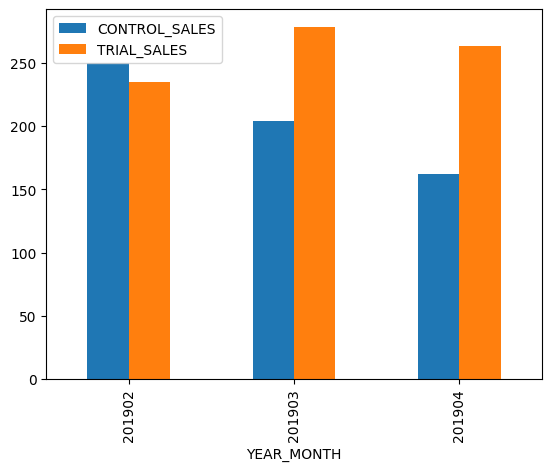

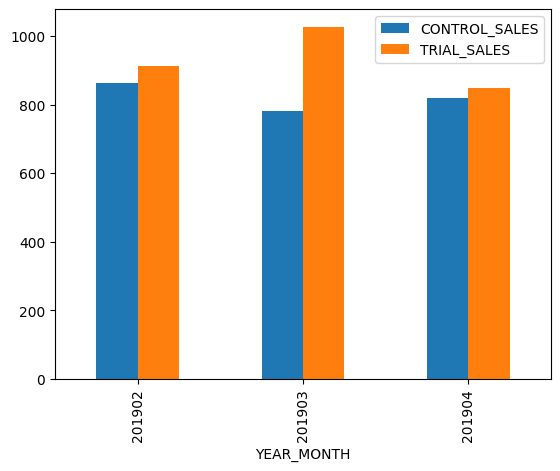

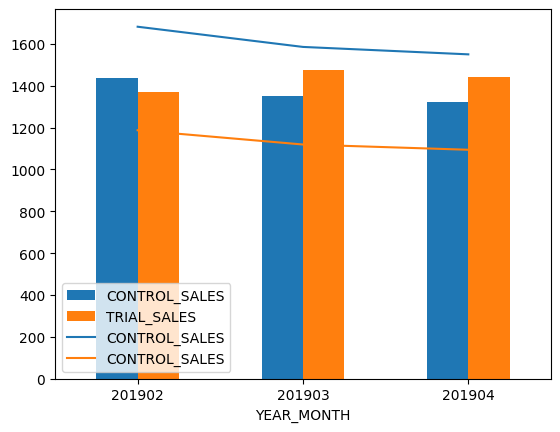

In [87]:
# start by looking at sales data during the trial period and plot
for stores in simStores:
    trial = stores[0]
    
    control = stores[1]
    ctrData = diff[(diff['CONTROL_NBR'] == control) * (diff.YEAR_MONTH >= 201902) & (diff.YEAR_MONTH <= 201904)][['YEAR_MONTH', 'CONTROL_NBR', 'SCALED_SALES_C']]
    ctrData = ctrData.rename(columns = {'CONTROL_NBR': 'STORE_NBR', 'SCALED_SALES_C': 'CONTROL_SALES'})
    trialData = diff[(diff['TRIAL_NBR'] == trial) & (diff.YEAR_MONTH >= 201902) & (diff.YEAR_MONTH <= 201904)][['YEAR_MONTH', 'TRIAL_NBR','TOTAL_SALES_T']]
    trialData = trialData.rename(columns = {'TRIAL_NBR': 'STORE_NBR', 'TOTAL_SALES_T':'TRIAL_SALES'})     
    ctrTrialData=ctrData[['YEAR_MONTH','CONTROL_SALES']].merge(trialData[['YEAR_MONTH','TRIAL_SALES']], on = 'YEAR_MONTH').set_index('YEAR_MONTH')
    ax = ctrTrialData.plot(kind='bar')
   

# we can also plot the 95th percentile threshold
std = diff[(diff['CONTROL_NBR'] == control) & (diff.YEAR_MONTH < 201902)]['SALES_PERCENT_DIFF'].std()
thresh95 = ctrData.reset_index()[['YEAR_MONTH', 'CONTROL_SALES']]
thresh95.CONTROL_SALES = thresh95.CONTROL_SALES*(1+std*2)
thresh5 = ctrData.reset_index()[['YEAR_MONTH', 'CONTROL_SALES']]
thresh5.CONTROL_SALES = thresh5.CONTROL_SALES*(1-std*2)
ax95 = thresh95.plot.line(x = 'YEAR_MONTH', y = 'CONTROL_SALES', use_index=False, ax = ax)
ax5 = thresh5.plot.line(x = 'YEAR_MONTH', y = 'CONTROL_SALES', use_index=False, ax=ax)

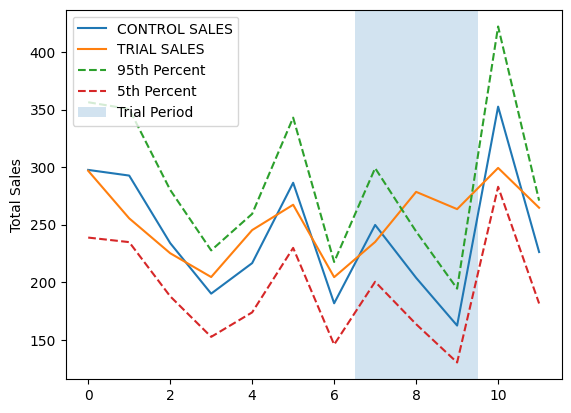

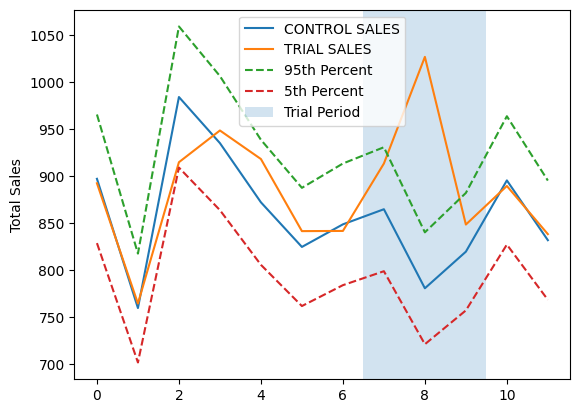

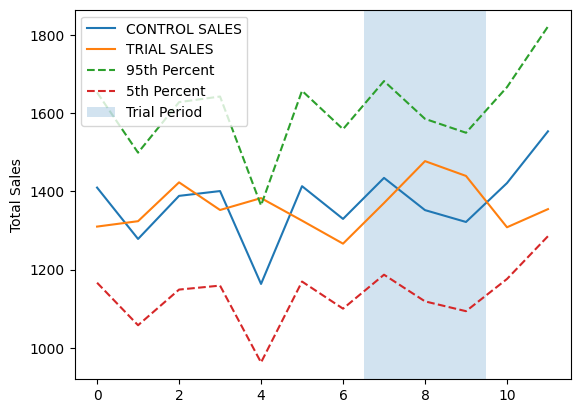

In [88]:
# now do the same for the whole year
for stores in simStores:
    trial = stores[0]
    control = stores[1]
    ctrData = diff[(diff['CONTROL_NBR'] == control)][['YEAR_MONTH', 'CONTROL_NBR', 'SCALED_SALES_C']]
    ctrData = ctrData.rename(columns = {'CONTROL_NBR': 'STORE_NBR','SCALED_SALES_C':'CONTROL_SALES'})
    trialData = diff[(diff['TRIAL_NBR'] == trial)][['YEAR_MONTH','TRIAL_NBR','TOTAL_SALES_T']]
    trialData = trialData.rename(columns = {'TRIAL_NBR':'STORE_NBR', 'TOTAL_SALES_T':'TRIAL_SALES'})
    ax = ctrData.plot.line(x='YEAR_MONTH', y = 'CONTROL_SALES', use_index=False, label = 'CONTROL SALES')
    ax_trial = trialData.plot.line(x='YEAR_MONTH', y = 'TRIAL_SALES', use_index = False, ax=ax, label = 'TRIAL SALES')
    
    # again we plot the 95-5 thresholds as lines
    std = diff[(diff['CONTROL_NBR'] == control) & (diff.YEAR_MONTH < 201902)]['SALES_PERCENT_DIFF'].std()
    thresh95 = ctrData.reset_index()[['YEAR_MONTH', 'CONTROL_SALES']]
    thresh95.CONTROL_SALES = thresh95.CONTROL_SALES*(1+std*2)
    thresh5 = ctrData.reset_index()[['YEAR_MONTH', 'CONTROL_SALES']]
    thresh5.CONTROL_SALES = thresh5.CONTROL_SALES*(1-std*2)
    ax95 = thresh95.plot.line(x = 'YEAR_MONTH', y = 'CONTROL_SALES', linestyle = '--', use_index =False, ax = ax, label = '95th Percent')
    ax5 = thresh5.plot.line(x = 'YEAR_MONTH', y = 'CONTROL_SALES', linestyle = '--', use_index =False, ax = ax, label = '5th Percent')
    ax.add_patch(Rectangle((6.5,0),3,2000, alpha = 0.2, label = 'Trial Period'))
    ax.set_ylabel('Total Sales')
    plt.legend()
    

We can see that store 77 performes very differently to its trial store as it lies outside of the confidence threshold. For store 86 we see a similar trend however there is no sugnificant differnce for store 88.

We can now do the same visualisations looking at customer data.

In [98]:
# scale our stores again for customer data and merge as we did before
scaled77 = pretrial2[pretrial2.STORE_NBR== 77]['TOTAL_CUST'].sum()/pretrial2[pretrial2.STORE_NBR == 233]['TOTAL_CUST'].sum()
scaled86 = pretrial2[pretrial2.STORE_NBR == 86]['TOTAL_CUST'].sum()/pretrial2[pretrial2.STORE_NBR == 155]['TOTAL_CUST'].sum()
scaled88 = pretrial2[pretrial2.STORE_NBR == 88]['TOTAL_CUST'].sum()/pretrial2[pretrial2.STORE_NBR == 40]['TOTAL_CUST'].sum()
scaled233 = dfMetrics[dfMetrics.STORE_NBR.isin([233])][['STORE_NBR','YEAR_MONTH','TOTAL_CUST']]
scaled233.TOTAL_CUST *= scaled77
scaled155 = dfMetrics[dfMetrics.STORE_NBR.isin([155])][['STORE_NBR','YEAR_MONTH','TOTAL_CUST']]
scaled233.TOTAL_CUST *= scaled86
scaled40 = dfMetrics[dfMetrics.STORE_NBR.isin([40])][['STORE_NBR','YEAR_MONTH','TOTAL_CUST']]
scaled233.TOTAL_CUST *= scaled88
scaledControls = pd.concat([scaled233, scaled155, scaled40]).reset_index(drop=True)
scaledControls = scaledControls.rename(columns = {'TOTAL_CUST':'SCALED_TOTAL_CUST', 'STORE_NBR':'CONTROL_NBR'})

# get the trial period of the stores as we did before
scaledControlsTrial = scaledControls[(scaledControls.YEAR_MONTH >=201902) & (scaledControls.YEAR_MONTH <= 201904)].reset_index(drop=True)
trialCust = dfMetrics[dfMetrics.STORE_NBR.isin([77,86,88])][['STORE_NBR','YEAR_MONTH','TOTAL_CUST']].reset_index(drop=True)
trialCust = trialCust.rename(columns = {'STORE_NBR': 'TRIAL_NBR'})
custTrialTrial = trialCust[(trialCust.YEAR_MONTH>=201902)&(trialSales.YEAR_MONTH<=201904)].reset_index(drop=True)

In [104]:
# again we calculate the percentage differenc between the control and trial store
percentDiff = scaledControls.copy()
percentDiff[['TRIAL_NBR', 'TOTAL_CUST_T']] = trialCust[['TRIAL_NBR','TOTAL_CUST']]
percentDiff = percentDiff.rename(columns = {'SCALED_TOTAL_CUST' : 'SCALED_TOTAL_CUST_C'})
percentDiff['CUST_PERCENT_DIFF'] = (percentDiff.TOTAL_CUST_T-percentDiff.SCALED_TOTAL_CUST_C/(0.5*((percentDiff.TOTAL_CUST_T+percentDiff.SCALED_TOTAL_CUST_C))))
print(percentDiff.head())

   CONTROL_NBR  YEAR_MONTH  SCALED_TOTAL_CUST_C  TRIAL_NBR  TOTAL_CUST_T  \
0          233      201807            52.239680         77            51   
1          233      201808            49.166758         77            47   
2          233      201809            43.020913         77            42   
3          233      201810            35.850761         77            37   
4          233      201811            40.972298         77            41   

   CUST_PERCENT_DIFF  
0          49.987992  
1          45.977469  
2          40.987992  
3          36.015775  
4          40.000338  


Our null hypothesis is that the trial period is the same as the pretrial perdiod. Let us conduct the same t-statisti test to check this.

In [109]:
pretrialPercentDiff = percentdiff[percentdiff.YEAR_MONTH < 201902]
pretrialPercentDiffStd = pretrialPercentDiff.groupby(['TRIAL_NBR'])['CUST_PERCENT_DIFF'].agg('std').reset_index()
dof = 7

for stores in simStores:
    trial = stores[0]
    control = stores[1]
    pretrial2 = percentDiff[(percentDiff.YEAR_MONTH < 201902) & ( percentDiff.TRIAL_NBR == trial)]
    std = pretrial2['CUST_PERCENT_DIFF'].agg('std')
    mean = pretrial2['CUST_PERCENT_DIFF'].agg('mean')
    trialPeriod = percentDiff[(percentDiff.YEAR_MONTH >= 201902) & (percentDiff.YEAR_MONTH <=201904) & (percentDiff.TRIAL_NBR == trial)]
    print('Trial store ' + str(trial) + ' with control ' + str(control))
    for month in trialPeriod.YEAR_MONTH.unique():
        xval = trialPeriod[trialPeriod.YEAR_MONTH == month]['CUST_PERCENT_DIFF'].item()
        tstat = ((xval-mean)/std)
        print(str(month), ':', tstat)

print('95th percent: ', stats.t.ppf(1-0.05,7))

Trial store 77 with control 233
201902 : 0.40263288184538515
201903 : 1.3040503603757887
201904 : 0.7943867539972973
Trial store 86 with control 155
201902 : 1.4247434248130497
201903 : 2.95473787912734
201904 : 1.0384914888348353
Trial store 88 with control 40
201902 : -0.35192375552289523
201903 : 1.6969029475009962
201904 : 0.47034413155562055
95th percent:  1.894578605061305


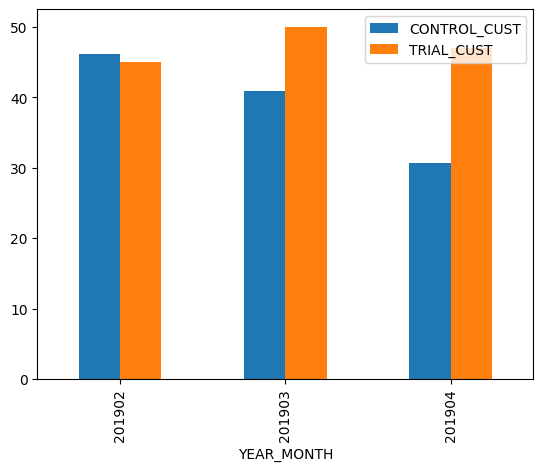

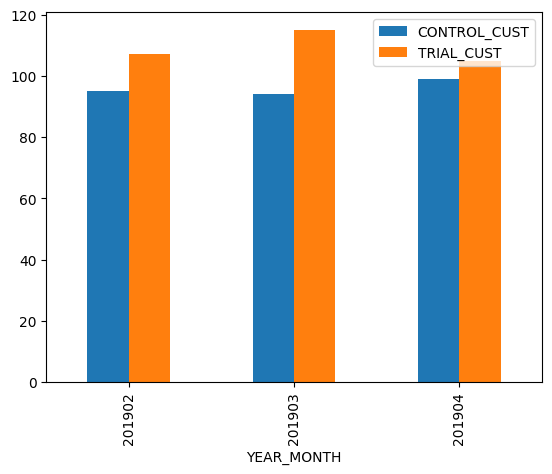

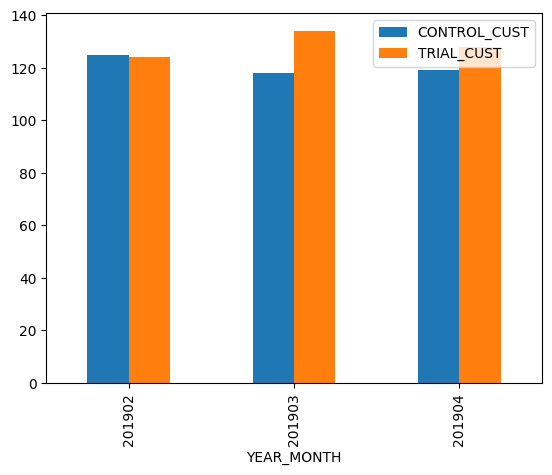

In [112]:
# we start the visualising again first by looking at the trial period
for stores in simStores:
    trial = stores[0]
    control = stores[1]
    ctrData = percentDiff[(percentDiff['CONTROL_NBR'] == control) & (percentDiff.YEAR_MONTH >= 201902) & (percentDiff.YEAR_MONTH <= 201904)][['YEAR_MONTH','CONTROL_NBR','SCALED_TOTAL_CUST_C']]
    ctrData = ctrData.rename(columns = {'CONTROL_NBR': 'STORE_NBR', 'SCALED_TOTAL_CUST_C':'CONTROL_CUST'})
    trialData = percentDiff[(percentDiff['TRIAL_NBR'] == trial) & (percentDiff.YEAR_MONTH >= 201902) & (percentDiff.YEAR_MONTH <= 201904)][['YEAR_MONTH','TRIAL_NBR','TOTAL_CUST_T']]
    trialData = trialData.rename(columns = {'TRIAL_NBR':'STORE_NBR', 'TOTAL_CUST_T':'TRIAL_CUST'})
    toplot = ctrData[['YEAR_MONTH','CONTROL_CUST']].merge(trialData[['YEAR_MONTH', 'TRIAL_CUST']], on='YEAR_MONTH').set_index('YEAR_MONTH')
    ax = toplot.plot(kind='bar')

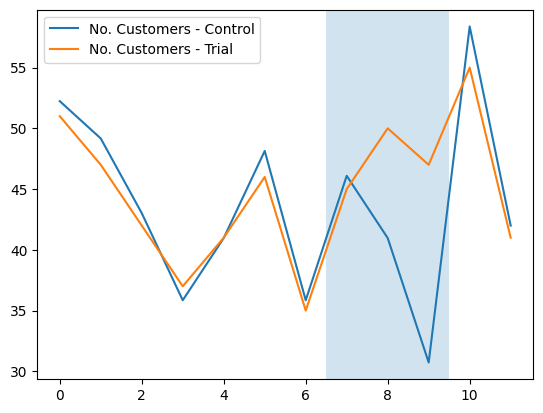

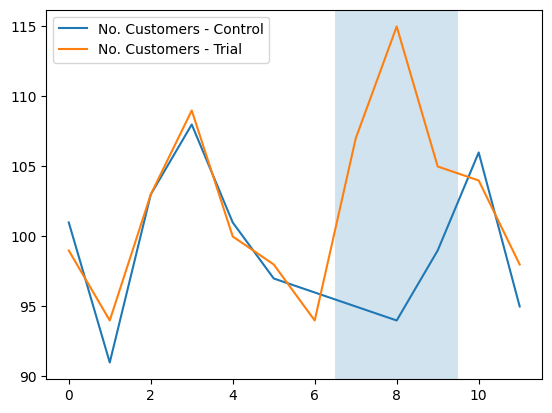

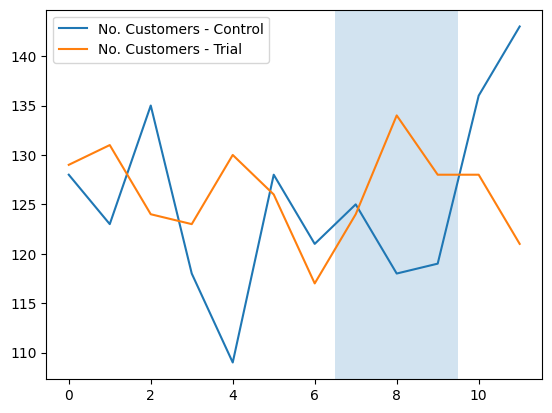

In [119]:
# lastly we will visualise the customer data for the whole year
for stores in simStores:
    trial = stores[0]
    control = stores[1]
    ctrData = percentDiff[(percentDiff['CONTROL_NBR'] == control)][['YEAR_MONTH','CONTROL_NBR','SCALED_TOTAL_CUST_C']]
    ctrData = ctrData.rename(columns = {'CONTROL_NBR':'STORE_NBR', 'SCALED_TOTAL_CUST_C': 'CONTROL_CUST'})
    trialData = percentDiff[(percentDiff['TRIAL_NBR'] == trial)][['YEAR_MONTH', 'TRIAL_NBR', 'TOTAL_CUST_T']]
    trialData = trialData.rename(columns = {'TRIAL_NBR':'STORE_NBR', 'TOTAL_CUST_T': 'TRIAL_CUST'})
    
    ax = ctrData.plot.line(x='YEAR_MONTH', y = 'CONTROL_CUST', use_index=False, label = 'No. Customers - Control')
    ax_trial = trialData.plot.line(x='YEAR_MONTH', y = 'TRIAL_CUST', use_index=False, ax=ax, label = 'No. Customers - Trial')
    
    #calculating and plotting the thresholds for the 95th percentile
    std = percentDiff[(percentDiff['CONTROL_NBR'] == control) & (percentDiff.YEAR_MONTH < 201902)]['CUST_PERCENT_DIFF'].std()
    thresh95 = ctrData.reset_index()[['YEAR_MONTH', 'CONTROL_CUST']]
    thresh95.CONTROL_CUST = thresh95.CONTROL_CUST*(1+std*2)
    thresh5 = ctrData.reset_index()[['YEAR_MONTH', 'CONTROL_CUST']]
    thresh5.CONTROL_CUST = thresh5.CONTROL_CUST*(1-std*2)
    ax.add_patch(Rectangle((6.5, 0), 3, 2000, alpha = 0.2, label = 'Trial period'))

For stroes 77 and 86 we again find customers are significanly hgiher in all three of the months sugesting the trial has a significant impact on increasing customers. Again with store 88 there is not much significance between the trial period and otherwise. We should check if there were any special incentives at  trial stowes that may have resulted in the data we see here.
We can potentialy say the trial may not have implemented the same in store 88 but we have no way of knowing any more about why it was underperforming compared to the other pairs. Overall we cna say that the trial resulted in an increase in the sales.